# Desafio
Construção de um modelo, a partir de um banco de dados fornecido pela Quantitas,  capaz de auxiliar na tomada de decisão de investimento em empresas da bolsa de valores.

Este modelo é dividido em 4 partes:

- Requisitos necessários para executar o modelo 
- Extração e limpeza dos dados
- Análise dos dados
- Elaboração do modelo de Machine Learning


__________________________________________________________________________________________

# Requisitos

## Bibliotecas built-in

In [1]:
# Manipulacao do banco de dados
import sqlite3 as sqlt
# Formatacao util de datas
from datetime import datetime
# Realizado de operacoes aritmeticas envolvendo datas. Subtracao de meses, por exemplo
import dateutil.relativedelta as oper_date
# Para ignorar os avisos de modulos obsoletos
import warnings

## Bibliotecas externas
Todas essas bibliotecas vem já inseridas na distribuiçao [Anaconda](https://www.anaconda.com/download/) do Python. É necessário elas estarem atualizadas.

In [2]:
# Manipulacao rápida de vetores
import numpy as np
# Manipulação de dataframes
import pandas as pd
# Extração de dados diretamente da web
import requests as req
# Elaboração de gráficos
import seaborn as sns
# Elaboração de gráficos
import matplotlib.pyplot as plt
# Elaboração do modelo de Machine Learning
from sklearn.linear_model import LinearRegression
# Teste da eficácia do modelo de Machine Learning
from sklearn import metrics

## Configurações

In [3]:
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style="whitegrid")

# Extração e limpeza dos dados

## Abertura do banco de dados

Os dados fornecidos estão no formato banco de dados relacional, logo são necessários alguns comandos em SQL para extrair os dados necessários para o modelo.

Querie pra extração das tuplas cujo atributo "Cod. Mun" seja igual ao código IBGE das cidades onde estão presentes Alpargatas/Grendene e que o atributo "NCM" começe por 6402, que é o NCM para "Outros calçados com sola exterior e parte superior de borracha ou plásticos".

In [4]:
querie_seleciona = """select * from MDIC_Exports where "Cod. Mun" in {} and 
"NCM" in (64029990, 64029900, 64029100, 64022000, 64029190, 64021900)"""
grendene_cidades = "(4307906, 4304804,  2312908, 2931350, 2304202, 2304400)"
alpargatas_cidades = "(2604007, 2504009, 3143302, 3530607)"

Execução dos queries acima descritos. Os resultados das consultas "querie_seleciona" são enviadas para 2 objetos da classe pandas.DataFrame, um para cada empresa. Essa classe facilita bastante a manipulação dos dados.

In [5]:
con = sqlt.connect("big_data2.db")
cursor = con.cursor()
grendene_db = pd.read_sql_query(querie_seleciona.format(grendene_cidades), con)
alpargatas_db = pd.read_sql_query(querie_seleciona.format(alpargatas_cidades), con)
con.close()

Amostra dos Dataframes

In [6]:
grendene_db.head(3)

,index,Cod. Mun,Desc. Mun,NCM,Desc. NCM,US$ de P1,Kg Liq de P1,Qtd de P1,month
0,571,2304202,CRATO-CE,64022000,"Calçados de borracha ou plásticos, com parte s...",247150,44329,66090,2003-01-01 00:00:00
1,634,2304400,FORTALEZA-CE,64022000,"Calçados de borracha ou plásticos, com parte s...",4917,894,2784,2003-01-01 00:00:00
2,764,2312908,SOBRAL-CE,64022000,"Calçados de borracha ou plásticos, com parte s...",6328919,1126374,2831893,2003-01-01 00:00:00


In [7]:
alpargatas_db.head(3)

,index,Cod. Mun,Desc. Mun,NCM,Desc. NCM,US$ de P1,Kg Liq de P1,Qtd de P1,month
0,912,2604007,CARPINA-PE,64022000,"Calçados de borracha ou plásticos, com parte s...",29443,9046,24312,2003-01-01 00:00:00
1,1055,2504009,CAMPINA GRANDE-PB,64022000,"Calçados de borracha ou plásticos, com parte s...",81044,14133,42720,2004-01-01 00:00:00
2,1056,2504009,CAMPINA GRANDE-PB,64029900,Outros calçados de borracha ou plástico,36720,7650,21600,2004-01-01 00:00:00


Informações sobre os DataFrames

In [8]:
grendene_db.info()
print("--------------------------")
alpargatas_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 9 columns):
index           1174 non-null int64
Cod. Mun        1174 non-null int64
Desc. Mun       1174 non-null object
NCM             1174 non-null int64
Desc. NCM       1174 non-null object
US$ de P1       1174 non-null object
Kg Liq de P1    1174 non-null object
Qtd de P1       1174 non-null int64
month           1174 non-null object
dtypes: int64(4), object(5)
memory usage: 82.6+ KB
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 9 columns):
index           435 non-null int64
Cod. Mun        435 non-null int64
Desc. Mun       435 non-null object
NCM             435 non-null int64
Desc. NCM       435 non-null object
US$ de P1       435 non-null object
Kg Liq de P1    435 non-null object
Qtd de P1       435 non-null int64
month           435 non-null object
dtypes: int64(4), object(5)
memory usage: 30.7+ KB


## Limpeza dos dados

Alguns atributos são desnecessários, estão com nomes ruins para manipulação ou estão em um formato não adequado para a análise, A  função "data_clean_db"  corrige isso.

In [9]:
def data_clean_db(dataframe):
    
    # Remoção de atributos desnecessários
    dataframe.drop(axis=1,columns=['Cod. Mun',"Desc. Mun", 'NCM', "Desc. NCM"]
                   ,inplace=True)
    
    # Renomeação dos atributos
    dict_nomes_colunas = {"month":"data","US$ de P1":"financeiro",
                          "Kg Liq de P1":"peso","Qtd de P1":"quantidade"}
    dataframe.rename(columns=dict_nomes_colunas,inplace=True)
    
    # Alteração de formatos. O atributo "data" é convertido para o tipo datetime 
    # e os atributos "financeiro" e "peso" para o tipo int
    dataframe.data = dataframe.data.apply(
        lambda data: datetime.strptime(data.split()[0], "%Y-%m-%d"))
    dataframe.set_index("index", inplace=True)
    dataframe.financeiro = dataframe.financeiro.astype("int")
    dataframe.peso = dataframe.peso.astype("int") 
    
    return dataframe

In [10]:
grendene_db = data_clean_db(grendene_db)
alpargatas_db = data_clean_db(alpargatas_db)

In [11]:
grendene_db.head(3)

,financeiro,peso,quantidade,data
index,,,,
571,247150,44329,66090,2003-01-01
634,4917,894,2784,2003-01-01
764,6328919,1126374,2831893,2003-01-01


In [12]:
alpargatas_db.head(3)

,financeiro,peso,quantidade,data
index,,,,
912,29443,9046,24312,2003-01-01
1055,81044,14133,42720,2004-01-01
1056,36720,7650,21600,2004-01-01


In [13]:
grendene_db.info()
print("--------------------------")
alpargatas_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1174 entries, 571 to 35701
Data columns (total 4 columns):
financeiro    1174 non-null int64
peso          1174 non-null int64
quantidade    1174 non-null int64
data          1174 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 45.9 KB
--------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 435 entries, 912 to 4305
Data columns (total 4 columns):
financeiro    435 non-null int64
peso          435 non-null int64
quantidade    435 non-null int64
data          435 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 17.0 KB


## Relação mensal das exportações

Os dataframes estao organizados de forma mensal,  porém os dados financeiro são fornecidos pelas empresas trimestralmente. Logo é necessário  agrupar os dados dos dataframes em trimestres. A função "get_meses_por_trimestres" realiza isso.

    - Trimestre 1: Jan | Fev | Mar
    - Trimestre 2: Abr | Mai | Jun
    - Trimestre 3: Jul | Ago | Set
    - Trimestre 4: Out | Nov | Dez

O dataframe retornado dessa função terá os seguintes atributos:

    - 1M_quantidade: Quantidade de itens exportados no primeiro mês do trimestre. Formato int 
    - 2M_quantidade: Quantidade de itens exportados no segundo mês do trimestre.  Formato int 
    - 3M_quantidade: Quantidade de itens exportados no terceiro mês do trimestre. Formato int 
    - acumulado_quantidade: A soma dos 3 atributos acima listados. Formato int 
    - acumulado_peso:  Total exportado em Kg no trimestre. Formato int 
    - acumulado_financeiro:  Total exportado em Dólar no trimestre.. Formato int 
    - trimestre: ano/mês final/01. Formato datetime


In [14]:

def get_meses_por_trimestres(db):
    
    # Lista doos ano de 2003 até 2017
    anos = list(range(2003,2018))
    # Lista dos meses finais de cada trimestre
    trimestres = [3, 6, 9, 12]
    
    # Instanciação do dataframe que será retornado
    df = pd.DataFrame(columns=
            ["1M_quantidade","2M_quantidade","3M_quantidade",
             "acumulado_quantidade","acumulado_peso",
             "acumulado_financeiro", "trimestre"])
    
    # Em alguns trimestres não há exportaçao no mês final. 
    mes3 = (lambda exportacao: exportacao[2] if len(exportacao) == 3 else 0)
    
    for ano in anos:
        for trimestre in trimestres:
            trimestre_ = datetime(ano, trimestre, 1)
            # Seleciona do dataframe todos as linhas cujo data seja anterior 
            # ou igual a "trimestre_" e posterior a ("trimestre_" - 3 meses)
            tab_trimestral = db[(db.data <= trimestre_) & 
                      (db.data > trimestre_ - oper_date.relativedelta(months=3))]
            
            # Obtém a quantidade de exportação de cada mes do trimestre
            quantidade_trimestral = tab_trimestral.groupby("data").quantidade.sum()
            
            # Inserção dos dados na tabela a ser retornada
            df = df.append(
                    {"1M_quantidade": quantidade_trimestral[0],
                    "2M_quantidade": quantidade_trimestral[1],
                     "3M_quantidade": mes3(quantidade_trimestral),
                     "acumulado_quantidade": quantidade_trimestral.sum(),
                     "acumulado_peso": tab_trimestral.peso.sum(),
                    "acumulado_financeiro": tab_trimestral.financeiro.sum(),
                     "trimestre": trimestre_
                    }, ignore_index=True)
            
    df.set_index("trimestre",inplace=True)
    
    # Seta como int o tipo de todos os atributos exceto o atributo "trimestre"
    df.iloc[:,0:7] = df.iloc[:,0:7].astype("int")
    
    return df

In [15]:
balanco_mensal_gren = get_meses_por_trimestres(grendene_db)
balanco_mensal_alp = get_meses_por_trimestres(alpargatas_db)

In [16]:
balanco_mensal_alp.head(3)

,1M_quantidade,2M_quantidade,3M_quantidade,acumulado_quantidade,acumulado_peso,acumulado_financeiro
trimestre,,,,,,
2003-03-01,24312,89426,151846,265584,89300,451930
2003-06-01,134123,90880,95295,320298,116540,485566
2003-09-01,62423,127778,0,190201,67050,196396


In [17]:
balanco_mensal_gren.head(3)

,1M_quantidade,2M_quantidade,3M_quantidade,acumulado_quantidade,acumulado_peso,acumulado_financeiro
trimestre,,,,,,
2003-03-01,2917687,2990283,2452614,8360584,3397023,18733681
2003-06-01,2197177,1767084,661129,4625390,1880988,11151631
2003-09-01,1046892,1678653,0,2725545,1077171,7352300


## Relação trimestral de exportações

### Alpargatas

Os dados que eu encontrei  estão no formato pdf, sendo que para cada trimestre esse pdf está com uma organização diferente. Isso dificulta bastante a extração automática dos dados. Por isso, para a Alpargatas optei por utilizar os dados fornecidos pela Quantitas no arquivo xlsx.

In [18]:
# Abertura do arquivo 
df = pd.read_excel("Exportação calçados.xlsx")

# Extração das colunas referentes a Alpargatas
df = df[["Unnamed: 2","Volume exportado Alpargatas"]]

# Renomeação dos atributos
df.rename(columns={"Unnamed: 2":"trimestre",
        "Volume exportado Alpargatas":"total_exportado"},inplace=True)

# Os trimestre já estão no formato datatime, porém o atributo "horas" está presente,
# por isso é preciso eliminar o atributo "horas"
df.trimestre = df.trimestre.apply(lambda data:data.date())

# Eliminação das linhas com valores NaN
df.dropna(inplace=True)

# Setagem do atributo "total_exportado" como tipo int
df.total_exportado = df.total_exportado.astype("int")

# Setagem do atributo "trimestre" como index do dataframe
df.reset_index(inplace=True)  
df.drop(columns="index",inplace=True)
df.set_index("trimestre",inplace=True)
balanco_trimestral_alp = df
balanco_trimestral_alp.head(4)

,total_exportado
trimestre,
2010-03-01,6500000
2010-06-01,7500000
2010-09-01,6100000
2010-12-01,6100000


### Grendene

Os dados trimestrais de exportação podem ser encontrados nesse [link](http://ri.grendene.com.br/Arquivos/Grendene_Informacoes_Financeiras_Download.xls)

In [19]:
# Abertura do arquivo e leitura do sheet "Volumes"
url = "http://ri.grendene.com.br/Arquivos/Grendene_Informacoes_Financeiras_Download.xls"
df = pd.read_excel(url, encoding="latin-1", sheet_name="Volumes")

# Extraçao das linhas 2 e 4. Essas linha serão respectivamente 
# as colunas "trimestre" e "total_exportado" do dataframe "balanco_trimestral_gren"
df.drop(columns="Grendene S.A.", inplace=True)
df = pd.DataFrame({"trimestre":df.iloc[2],
                                  "total_exportado":df.iloc[4]})

# Resetagem do index
df.reset_index(inplace=True)
df.drop(axis=1, columns=["index"], inplace=True)

# Eliminação das linhas nao relacionadas com trimestres 
df = df[df.trimestre.str[1] == "T"]

# Setagem do atributo "trimestre" como formato datetime
def get_datetime(string):
    mes, ano = string.split("T")
    ano = "20" + ano
    dict_mes = {"1":3, "2":6, "3":9, "4":12}
    return datetime(int(ano), dict_mes[mes], 1)

df.trimestre = df.trimestre.apply(
    lambda string:get_datetime(string))

# Correção do ordem de grandeza do atributo "total_exportado"
df.total_exportado = df.total_exportado.apply(
    lambda exportacao:exportacao*1000)

# Setagem do atributo "trimestre" como index
df.set_index("trimestre", inplace=True)
balanco_trimestral_gren = df
balanco_trimestral_gren.head(3)

,total_exportado
trimestre,
2007-03-01,13152000
2007-06-01,6324000
2007-09-01,7609000


Os dataframe mensais e trimestrais de cada empresa estão com shapes diferentes. É preciso corigir isso.

In [20]:
balanco_mensal_gren = balanco_mensal_gren.iloc[16:]
balanco_trimestral_gren = balanco_trimestral_gren.iloc[:-1,]

balanco_mensal_gren.info()
print("###########################################")
balanco_trimestral_gren.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2007-03-01 to 2017-12-01
Data columns (total 6 columns):
1M_quantidade           44 non-null int64
2M_quantidade           44 non-null int64
3M_quantidade           44 non-null int64
acumulado_quantidade    44 non-null int64
acumulado_peso          44 non-null int64
acumulado_financeiro    44 non-null int64
dtypes: int64(6)
memory usage: 2.4 KB
###########################################
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2007-03-01 to 2017-12-01
Data columns (total 1 columns):
total_exportado    44 non-null int64
dtypes: int64(1)
memory usage: 704.0 bytes


In [21]:
balanco_mensal_alp = balanco_mensal_alp.iloc[28:]
balanco_mensal_alp.info()
print("##########################")
balanco_trimestral_alp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32 entries, 2010-03-01 to 2017-12-01
Data columns (total 6 columns):
1M_quantidade           32 non-null int64
2M_quantidade           32 non-null int64
3M_quantidade           32 non-null int64
acumulado_quantidade    32 non-null int64
acumulado_peso          32 non-null int64
acumulado_financeiro    32 non-null int64
dtypes: int64(6)
memory usage: 1.8 KB
##########################
<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 2010-03-01 to 2017-12-01
Data columns (total 1 columns):
total_exportado    32 non-null int64
dtypes: int64(1)
memory usage: 512.0+ bytes


União dos dataframes mensais e trimestrais de cada empresa. Esse formato facilita a análise.

In [22]:
relacao_men_trim_gren = balanco_mensal_gren.copy()
relacao_men_trim_gren["quantidade_anunciada_trimestre"] = balanco_trimestral_gren

relacao_men_trim_alp = balanco_mensal_alp.copy()
relacao_men_trim_alp["quantidade_anunciada_trimestre"] = balanco_trimestral_alp

_____________________________

# Análise dos dados

## Alpargatas

Podemos ver que não há um regressão linear muito forte entre o atributo "quantidade_anunciada_trimestre" e os demais atributos.

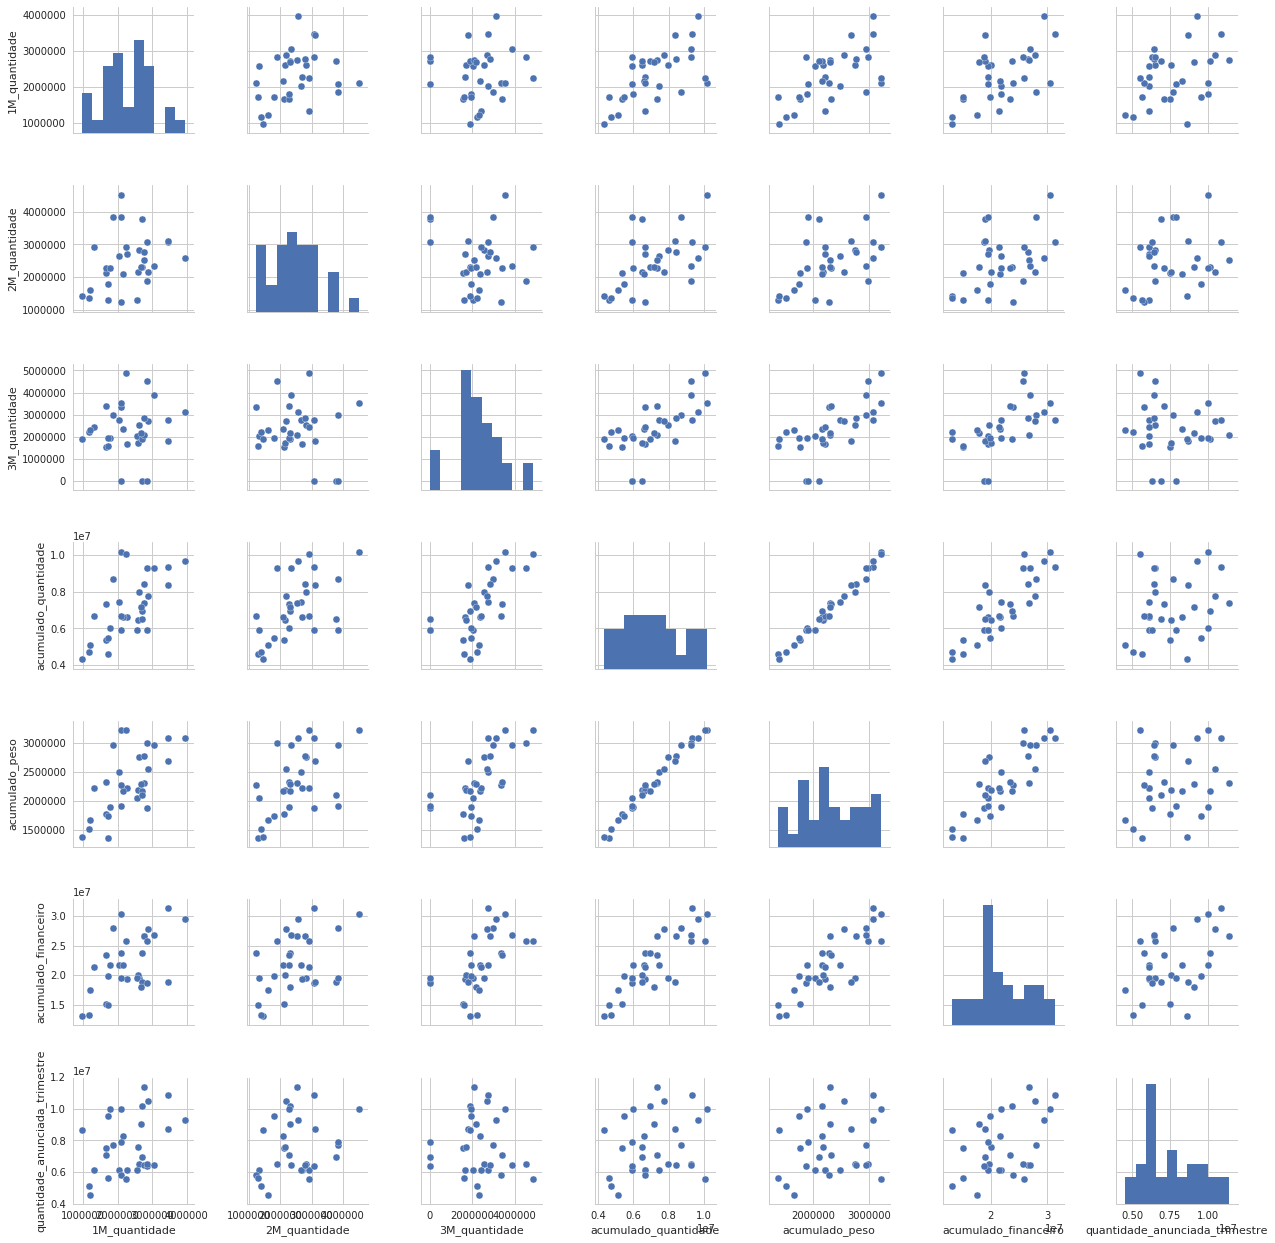

In [23]:
sns.pairplot(relacao_men_trim_alp)

## Grendene 

Podemos ver que há um regressão linear forte entre o atributo "quantidade_anunciada_trimestre" e os demais atributos. Nos testes de eficiência do método de machine learning que será abordado em seguida foi verificado que utilizar os atributos "1M_quantidade",  "2M_quantidade" e "3M_quantidade" são a melhor combinação para prever  "quantidade_anunciada_trimestre". 

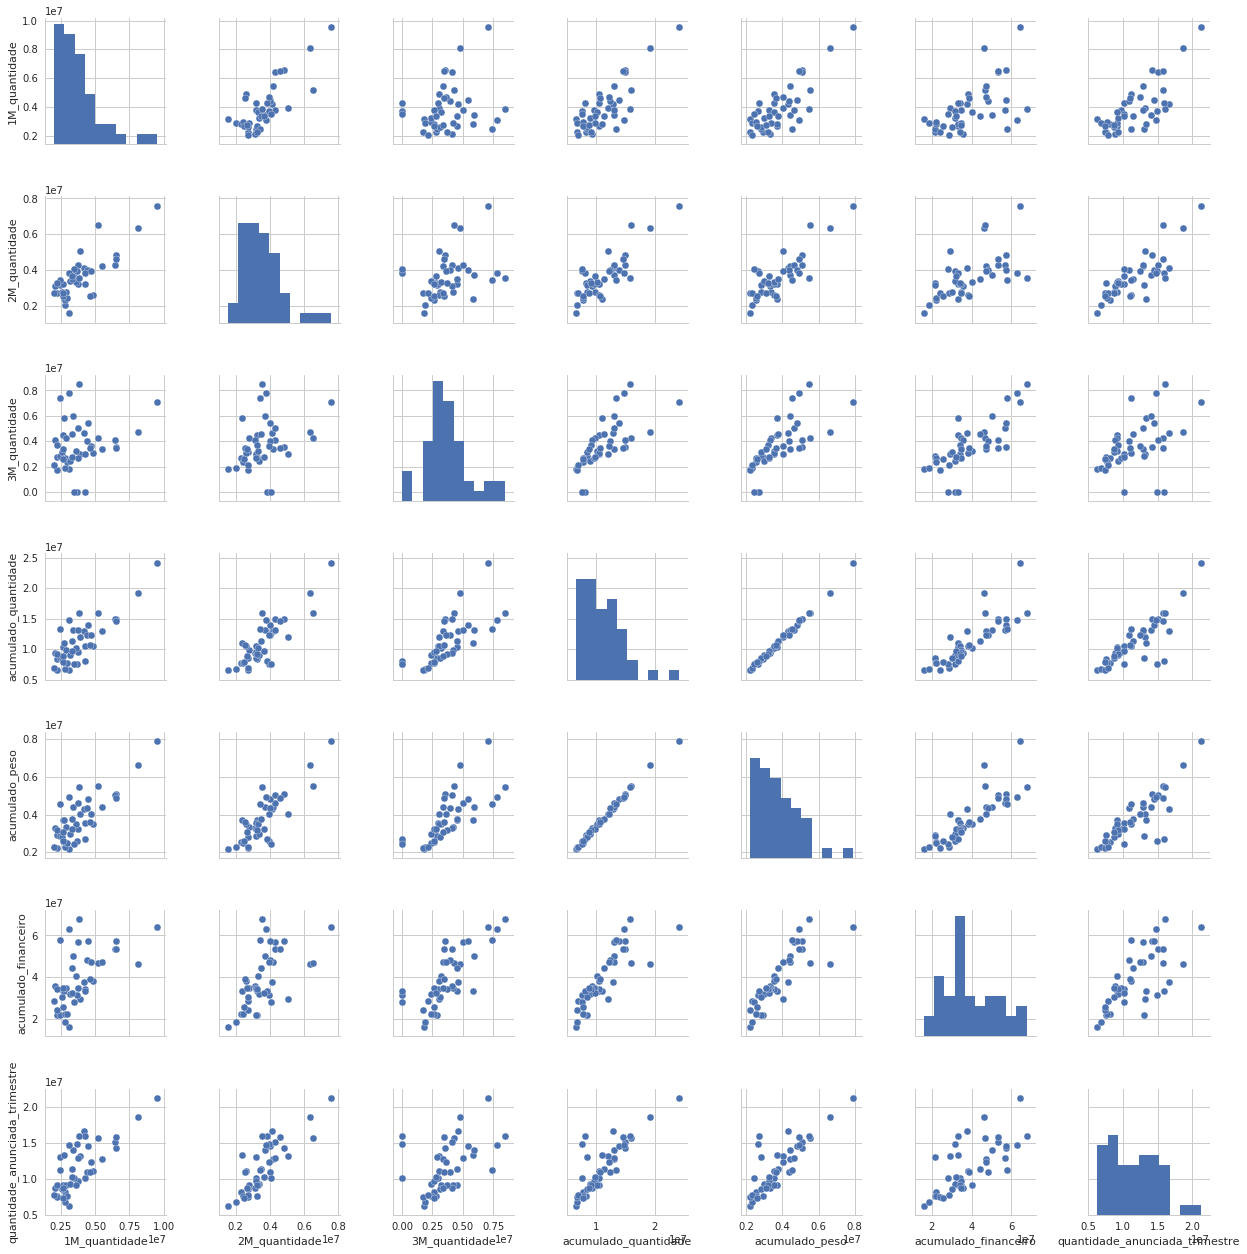

In [24]:
sns.pairplot(relacao_men_trim_gren)

_____________________________________________________________

# Machine Learning


## Alpargatas

Através da análise do pairplot de relacao_mensal_trimestral_alp foi verificado que não há uma regressão linear evidente entre "quantidade_anunciada_trimestre", porém é valido ao mesmo testar a eficiência de um método de regressão linear com seus dados. Os atributos que representarão os coeficientes dessa equação linaear serão "1M_quantidade",  "2M_quantidade" e "3M_quantidade".

### Treinamento

In [25]:
# Instanciação de um objeto da classe LinearRegression
lm_alp = LinearRegression()

#Separação dos dados entre entrada/saida e treino/teste
x_train_alp = balanco_mensal_alp.iloc[:22,:3]
x_test_alp = balanco_mensal_alp.iloc[22:,:3]
y_train_alp = balanco_trimestral_alp.iloc[:22]
y_test_alp = balanco_trimestral_alp.iloc[22:]

# Treinamento do objeto LinearRegression
lm_alp.fit(x_train_alp, y_train_alp)

# Impressão dos coeficiente da regressão
coeff_df_alp = pd.DataFrame(lm_alp.coef_[0],x_train_alp.columns,columns=['Coeficientes'])
coeff_df_alp

,Coeficientes
1M_quantidade,1.223351
2M_quantidade,0.459435
3M_quantidade,0.466947


### Histograma residual

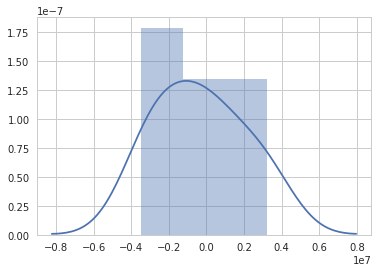

In [26]:
predictions_alp = lm_alp.predict(x_test_alp)
sns.distplot(y_test_alp-predictions_alp)

### Gráfico EXPORTAÇÕES REALIZADAS x EXPORTAÇÕES PREVISTAS 
Os valores são bem diferentes, porém é perceptível, principalmente entre 2015/8 e 2017/2, que a linha "exportações realizadas" é parecida com a linha "exportações previstas" transladada 1 trimestre para a direita. Não consegui identificar o que causa isso. A extraçao e limpeza dos dados foram realizadas da forma correta. Isso ocorra talvez por causa de alguma regra de negócio da Alpagartas, algo como exportar somente aquilo que foi produzido 1 trimestre antes.

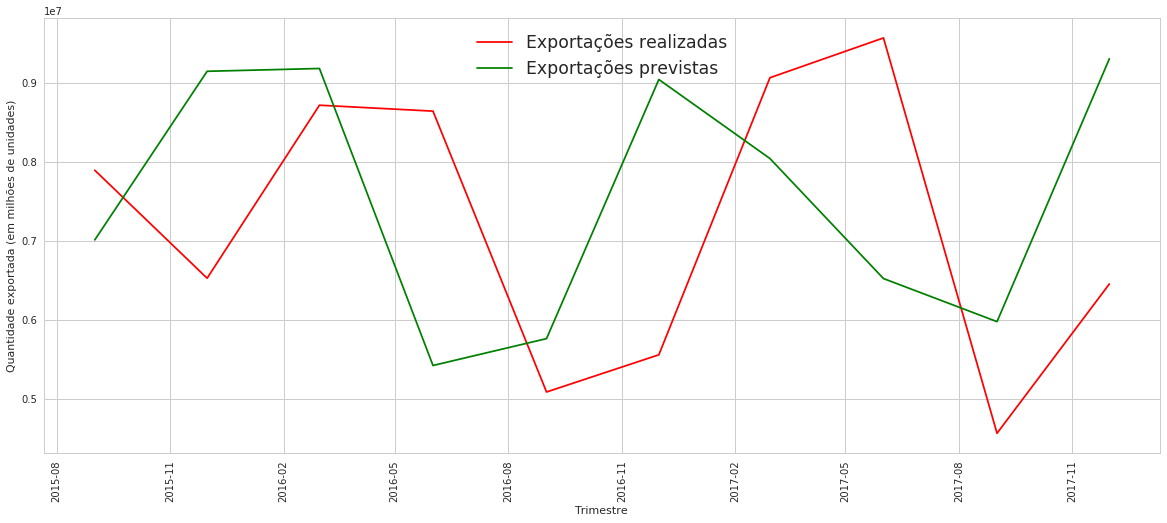

In [27]:
a = y_test_alp.index
c = y_test_alp
d = predictions_alp
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(a, c, 'red', label='Exportações realizadas')
ax.plot(a, d, 'green', label='Exportações previstas')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.ylabel("Quantidade exportada (em milhões de unidades)")
plt.xlabel("Trimestre")
plt.xticks(rotation='vertical')
plt.show()


### Métricas de avaliação

In [28]:
print('MAE:', metrics.mean_absolute_error(y_test_alp, predictions_alp))
print('MSE:', metrics.mean_squared_error(y_test_alp, predictions_alp))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_alp, predictions_alp)))

MAE: 1968760.9803126603
MSE: 5131947474405.342
RMSE: 2265380.2052647457


## Grendene

### Treinamento

In [29]:
# Instanciação de um objeto da classe LinearRegression
lm_gren = LinearRegression()

#Separação dos dados entre entrada/saida e treino/teste
x_train_gren = balanco_mensal_gren.iloc[:30,:3]
x_test_gren = balanco_mensal_gren.iloc[30:,:3]
y_train_gren = balanco_trimestral_gren.iloc[:30]
y_test_gren = balanco_trimestral_gren.iloc[30:]


# Treinamento do objeto LinearRegression
lm_gren.fit(x_train_gren, y_train_gren)

# Impressão dos coeficientes da regressão
coeff_df_gren = pd.DataFrame(lm_gren.coef_[0],x_train_gren.columns,columns=['Coficientes'])
coeff_df_gren

,Coficientes
1M_quantidade,0.591435
2M_quantidade,1.471495
3M_quantidade,0.496986


### Histograma residual

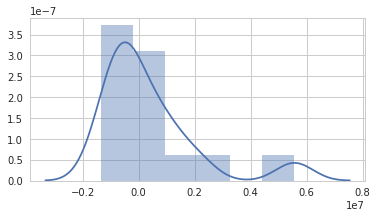

In [30]:
plt.figure(figsize=(6,3))
predictions_gren = lm_gren.predict(x_test_gren)
sns.distplot(y_test_gren-predictions_gren)

### Gráfico EXPORTAÇÕES REALIZADAS x EXPORTAÇÕES PREVISTAS
Valores parecidos exceto em 2014/12. Uma explicação para isso é que nesse trimestre e em 2013/12 houve regressão linear inversa do que foi produzido mensalmente sobre o que foi exportado no final do trimestre, diferente de outros trimestres onde houve regressão linear direta.

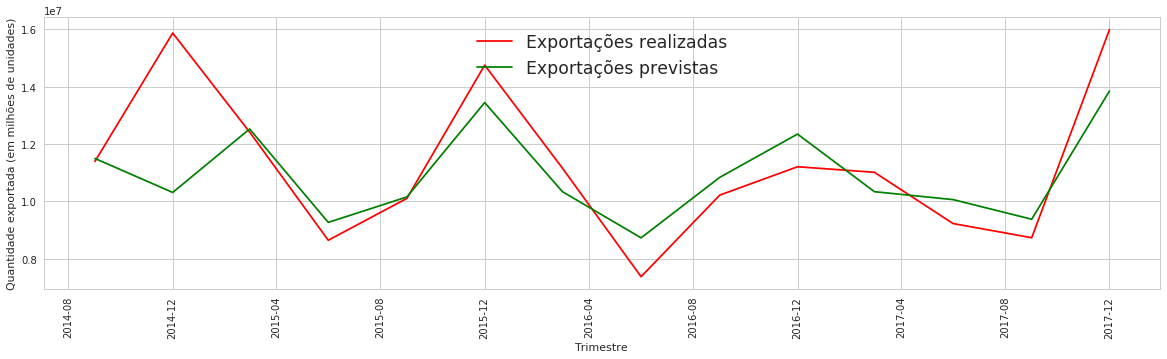

In [31]:
a = y_test_gren.index
c = y_test_gren
d = predictions_gren
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(a, c, 'red', label='Exportações realizadas')
ax.plot(a, d, 'green', label='Exportações previstas')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.ylabel("Quantidade exportada (em milhões de unidades)")
plt.xlabel("Trimestre")
plt.xticks(rotation='vertical')
plt.show()

### Métricas de avaliação

In [32]:
print('MAE:', metrics.mean_absolute_error(y_test_gren, predictions_gren))
print('MSE:', metrics.mean_squared_error(y_test_gren, predictions_gren))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_gren, predictions_gren)))

MAE: 1141781.4946881982
MSE: 3100135179471.802
RMSE: 1760720.0741377948
